# Himanshu MDS202327

In [ ]:
!pip install adjustText

In [ ]:
# Importing relevant libraries
import json
import re
import string
import os
import glob
import multiprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download("stopwords", quiet=True)
nltk.download('punkt', quiet=True)

from multiprocessing import Pool, cpu_count, Lock
from functools import partial
from tqdm import tqdm
from collections import Counter, defaultdict
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from nltk.corpus import stopwords
from IPython.display import display, Math

from nltk import ngrams, word_tokenize, sent_tokenize

import scipy
from scipy.sparse import dok_matrix, csr_matrix, lil_matrix
from scipy.spatial.distance import euclidean, cosine

import joblib
import gc

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from adjustText import adjust_text

Note: I have taken the vocabulary size to be 1000 since I ran out of TPU and my laptop is really slow. Hope its understandable.

### Task 1
Implement a modified version of COALS (refer to this paper for COALS implementation) using
the COVID corpus.

Instead of the using correlation, use the ratio of the probabilities $\frac{P_{ik}}{P_{jk}}$ to obtain the cooccurrence matrix


In [ ]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
corpus_path_drive = '/content/drive/MyDrive/NLP/corpus_cleaned.txt'

In [ ]:
def preprocess_text(text):
    text = re.sub(r'[^a-z\s]', '', text.lower())
    return text.split()

def get_vocab(flat_corpus, vocab_size):
    word_counts = Counter(flat_corpus)
    most_common = word_counts.most_common(vocab_size)
    return [word for word, _ in most_common]

def get_flat_corpus(corpus_path_drive):
    with open(corpus_path_drive, 'r') as f:
        lines = f.readlines()
    corpus = [preprocess_text(line) for line in lines]
    flat_corpus = [word for line in corpus for word in line]
    return flat_corpus

In [ ]:
flat_corpus = get_flat_corpus(corpus_path_drive)
joblib.dump(flat_corpus,"/content/drive/MyDrive/NLP/flat_corpus.pickle")

['/content/drive/MyDrive/NLP/flat_corpus.pickle']

In [ ]:
vocab = get_vocab(flat_corpus, 1000)
joblib.dump(vocab,"/content/drive/MyDrive/NLP/vocab.pickle")

['/content/drive/MyDrive/NLP/vocab.pickle']

In [ ]:
print(f'Size of the vocabulary: {len(vocab)}')

Size of the vocabulary: 1000


In [ ]:
vocab_index = {word: i for i, word in enumerate(vocab)}
joblib.dump(vocab_index,"/content/drive/MyDrive/NLP/vocab_idx.pickle")

['/content/drive/MyDrive/NLP/vocab_idx.pickle']

In [ ]:
def compute_matrix(flat_corpus, vocab_index, window_size=4):
    cooccurrence_matrix = lil_matrix((len(vocab_index), len(vocab_index)), dtype=np.float32)

    for i, word in enumerate(flat_corpus):
        if word not in vocab_index:
            continue
        word_idx = vocab_index[word]
        for j in range(1, window_size + 1):
            if i + j < len(flat_corpus):
                neighbor = flat_corpus[i + j]
                if neighbor in vocab_index:
                    neighbor_idx = vocab_index[neighbor]
                    cooccurrence_matrix[word_idx, neighbor_idx] += (window_size - j + 1)
            if i - j >= 0:
                neighbor = flat_corpus[i - j]
                if neighbor in vocab_index:
                    neighbor_idx = vocab_index[neighbor]
                    cooccurrence_matrix[word_idx, neighbor_idx] += (window_size - j + 1)
    return cooccurrence_matrix.tocsr()

In [ ]:
cooccurrence_matrix = compute_matrix(flat_corpus, vocab_index)
joblib.dump(cooccurrence_matrix,"/content/drive/MyDrive/NLP/cooccurrence_matrix.pickle")

['/content/drive/MyDrive/NLP/cooccurrence_matrix.pickle']

In [ ]:
df = pd.DataFrame.sparse.from_spmatrix(cooccurrence_matrix, index=vocab, columns=vocab)
df.iloc[30:40, 30:40]

,these,has,s,can,cells,covid,also,been,may,data
these,1756.0,1991.0,2260.0,8147.0,9148.0,2565.0,5346.0,3826.0,7978.0,13919.0
has,1991.0,690.0,2473.0,302.0,1840.0,10389.0,15873.0,155516.0,324.0,1827.0
s,2260.0,2473.0,50378.0,2236.0,1599.0,1561.0,2341.0,1168.0,1488.0,2873.0
can,8147.0,302.0,2236.0,624.0,4107.0,2971.0,17206.0,434.0,253.0,3638.0
cells,9148.0,1840.0,1599.0,4107.0,15206.0,514.0,4202.0,1910.0,2922.0,891.0
covid,2565.0,10389.0,1561.0,2971.0,514.0,4124.0,2762.0,3719.0,4094.0,3353.0
also,5346.0,15873.0,2341.0,17206.0,4202.0,2762.0,234.0,17642.0,15599.0,2988.0
been,3826.0,155516.0,1168.0,434.0,1910.0,3719.0,17642.0,298.0,2962.0,1441.0
may,7978.0,324.0,1488.0,253.0,2922.0,4094.0,15599.0,2962.0,2194.0,1955.0
data,13919.0,1827.0,2873.0,3638.0,891.0,3353.0,2988.0,1441.0,1955.0,7310.0


In [ ]:
def compute_pmatrix(X):
    n = X.shape[0]
    row_sums = X.sum(axis=1).A1
    epsilon = 1e-10
    row_sums = np.where(row_sums == 0, epsilon, row_sums)
    X_new = X / row_sums[:, np.newaxis]
    X_new = csr_matrix(X_new)

    word_vectors = np.zeros((n, n), dtype = np.float32)
    for j in tqdm(range(n)):
      k = np.argmax(X_new[j, :])
      p_jk = X_new[j, k]
      for i in range(n):
        word_vectors[i, j] = X_new[i, k]/p_jk
    return csr_matrix(word_vectors)

In [ ]:
p_matrix = compute_pmatrix(cooccurrence_matrix)
joblib.dump(p_matrix,"/content/drive/MyDrive/NLP/p_matrix.pickle")

100%|██████████| 1000/1000 [00:30<00:00, 32.81it/s]


['/content/drive/MyDrive/NLP/p_matrix.pickle']

In [ ]:
df = pd.DataFrame.sparse.from_spmatrix(p_matrix, index=vocab, columns=vocab)
df.iloc[30:40, 30:40]

,these,has,s,can,cells,covid,also,been,may,data
these,1.000000,0.025351,0.418819,0.059994,0.592765,0.476992,0.696514,0.011982,0.079788,0.403640
has,0.299186,1.000000,0.623018,0.029045,0.365850,0.709554,1.036105,0.004030,0.038628,0.600437
s,0.564004,0.008355,1.000000,0.018582,0.485403,1.138897,1.663041,0.016067,0.024712,0.963756
can,0.289363,0.003096,0.535674,1.000000,0.353311,0.610078,0.890849,0.001957,1.329931,0.516259
cells,0.707162,0.015081,0.683350,0.023148,1.000000,0.778266,1.136440,0.013196,0.030785,0.658583
covid,1.008410,0.024541,0.878042,0.031128,0.709778,1.000000,1.460221,0.062268,0.041398,0.846218
also,0.279751,0.132800,0.601308,0.155888,0.449965,0.684828,1.000000,0.108526,0.207320,0.579514
been,0.179850,0.002110,0.333516,0.033203,0.597045,0.379840,0.554651,1.000000,0.044158,0.321428
may,0.347806,0.024345,0.518851,0.751919,0.402275,0.590918,0.862870,0.002419,1.000000,0.500045
data,0.571554,0.012520,1.037607,0.039622,0.398180,1.181728,1.725584,0.014418,0.052695,1.000000


In [ ]:
print(f'Size of the matrix: {p_matrix.shape}')

Size of the matrix: (1000, 1000)


In [ ]:
p_matrix = joblib.load("/content/drive/MyDrive/NLP/p_matrix.pickle")
vocab_index = joblib.load("/content/drive/MyDrive/NLP/vocab_idx.pickle")
cooccurrence_matrix = joblib.load("/content/drive/MyDrive/NLP/cooccurrence_matrix.pickle")
vocab = joblib.load("/content/drive/MyDrive/NLP/vocab.pickle")

### Task 2
Identify five nouns and verbs (relevant to
COVID19) from the corpus.

Generate five similar words for each (chosen in
step b) and display the result with cosine
distance for each one.

In [ ]:
vocab_index_rev = dict(zip(vocab_index.values(),vocab_index))

In [ ]:
def normalize_matrix_rows(X):
    row_norms = np.sqrt(X.multiply(X).sum(axis=1))
    row_norms[row_norms == 0] = 1e-10
    return X.multiply(1 / row_norms)

def get_similar(X, chosen_indices, n=5):
    X_normalized = normalize_matrix_rows(X)
    X_normalized_dense = X_normalized.toarray()
    results = {}

    for idx in chosen_indices:
        similarities = []
        chosen_word_vector = X_normalized_dense[idx]
        for i in range(X_normalized_dense.shape[0]):
            if i != idx:
                other_word_vector = X_normalized_dense[i]
                cos_sim = 1 - cosine(chosen_word_vector, other_word_vector)
                similarities.append((i, cos_sim))
        similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:n]
        results[idx] = similarities
    return results

In [ ]:
chosen_words = ['pandemic','research','sequence','symptoms','animal']
chosen_indices = [vocab_index[i] for i in chosen_words]
similar_words = get_similar(p_matrix, chosen_indices, n=5)

In [ ]:
for chosen_idx, similar_list in similar_words.items():
    print(f"Word: {vocab_index_rev[chosen_idx]}")
    for sim_idx, cos_sim in similar_list:
        print(f"Cosine Similarity: {cos_sim:.4f}; Similar Word: {vocab_index_rev[sim_idx]}")
    print()

Word: pandemic
Cosine Similarity: 0.9990; Similar Word: first
Cosine Similarity: 0.9990; Similar Word: crisis
Cosine Similarity: 0.9989; Similar Word: current
Cosine Similarity: 0.9987; Similar Word: second
Cosine Similarity: 0.9986; Similar Word: during

Word: research
Cosine Similarity: 0.9986; Similar Word: conditions
Cosine Similarity: 0.9982; Similar Word: online
Cosine Similarity: 0.9981; Similar Word: drug
Cosine Similarity: 0.9979; Similar Word: cell
Cosine Similarity: 0.9977; Similar Word: groups

Word: sequence
Cosine Similarity: 0.9996; Similar Word: product
Cosine Similarity: 0.9994; Similar Word: domain
Cosine Similarity: 0.9992; Similar Word: peak
Cosine Similarity: 0.9992; Similar Word: full
Cosine Similarity: 0.9991; Similar Word: structure

Word: symptoms
Cosine Similarity: 0.9965; Similar Word: diseases
Cosine Similarity: 0.9965; Similar Word: inhibitors
Cosine Similarity: 0.9951; Similar Word: age
Cosine Similarity: 0.9950; Similar Word: illness
Cosine Similarity: 0.

### Task 3
Use multi-dimensional scaling to visualize
certain concepts (relevant to COVID 19) as
shown in Fig.1. Take three concepts that you
feel are relevant to this corpus and use a
maximum of 10 words per concept. Make sure
that the plot is clear and not cluttered


In [ ]:
sim = []
chosen_words = ['pandemic','research','symptoms']
chosen_indices = [vocab_index[i] for i in chosen_words]
similar_words = get_similar(p_matrix, chosen_indices, n=10)
for k in similar_words:
  sim.append([vocab_index_rev[k]]+[vocab_index_rev[i] for i,j in similar_words[k]])

In [ ]:
# will plot the list of lists of the similar words to the nouns
def plot_similar(X, vocab_index, sim):

    # some initializations
    k = len(sim[0])
    num_clusters = len(sim)
    sim = np.array(sim).flatten()

    # list of word vectors for all the words in the similar list
    pts = np.array([(lambda a2:a2/np.linalg.norm(a2))(X[vocab_index[w],:].toarray().flatten()) for w in sim])

    # Applying t-SNE with the perplexity set to the number of words in 'nouns'
    pts_emb = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=num_clusters).fit_transform(pts)

    # Taking transpose of the above
    pts_emb = [list(i) for i in zip(*pts_emb)]
    X = pts_emb[0];Y = pts_emb[1]

    # Generating num_clusters number of random colours
    clrs = [np.random.random(3) for _ in range(num_clusters)]
    clrs = sum([[x]*k for x in clrs],[])  # Expanding to give colour to each point

    plt.figure(figsize=(8,6), dpi=120)

    plt.scatter(X,Y, s= 10,c = np.array(clrs))
    plt.axis('off')

    # Adding label to each point
    texts = [plt.text(X[i], Y[i], txt, size = 6.5) for i, txt in enumerate(sim)]
    adjust_text(texts)

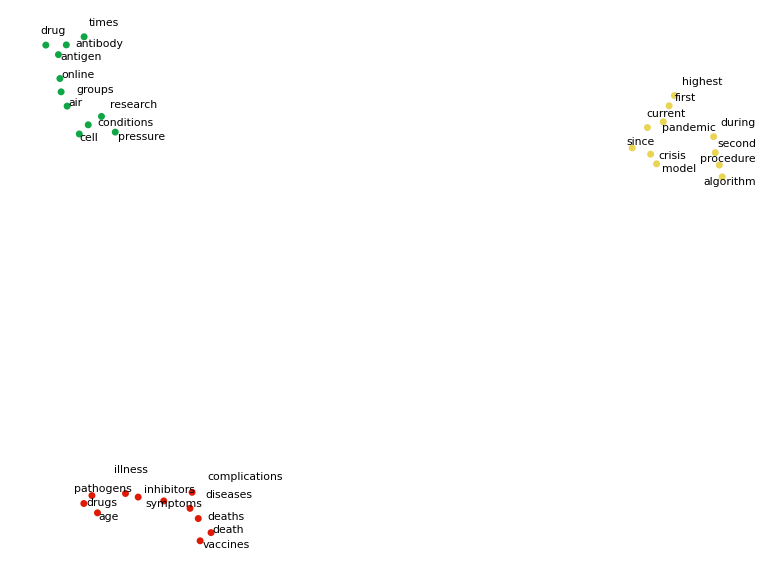

In [ ]:
plot_similar(p_matrix, vocab_index, sim)